In [35]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

if torch.cuda.is_available():
    device_string = "cuda"
elif torch.backends.mps.is_available():
    device_string = "mps"
else:
    device_string = "cpu"
device = torch.device(device_string)
model = SamModel.from_pretrained("/Users/rstory/Repositories/SlimSAM-uniform-77")
processor = SamProcessor.from_pretrained("/Users/rstory/Repositories/SlimSAM-uniform-77")

In [36]:
device_string

'mps'

In [59]:
import xml.etree.ElementTree as ET

def extract_boxes(filename):
    # Parse the XML file
    tree = ET.parse(filename)
    root = tree.getroot()

    # List to hold the bounding boxes
    boxes = []

    # Iterate over each 'object' element in the XML
    for obj in root.iter('object'):
        # Get the bounding box coordinates
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Add the bounding box to the list
        boxes.append([xmin, ymin, xmax, ymax])

    return boxes

# Use the function
boxes = extract_boxes('/Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/0 - 20240124205354-PB3 Waterjet Lorax channel 1-1201-0-8 53 55 PM.xml')
boxes

[[1320, 427, 1408, 505], [874, 725, 968, 819]]

In [69]:
def boxes_to_coordinates(boxes: list[int]) -> list[list[int]]:
    # Convert a list of boxes (a list of xmin, xmax, ymin, ymax) to a list of coordinates (a list of x, y)
    new_list = []
    for box in boxes:
        coordinates = []
        xmin, ymin, xmax, ymax = box
        coordinates.append([xmin, ymin])
        coordinates.append([xmax, ymin])
        coordinates.append([xmax, ymax])
        coordinates.append([xmin, ymax])
        new_list.append(coordinates)
    return new_list

coordinates = boxes_to_coordinates(boxes)
coordinates

[[[1320, 427], [1408, 427], [1408, 505], [1320, 505]],
 [[874, 725], [968, 725], [968, 819], [874, 819]]]

In [ ]:
input_boxes = [[[650, 900, 1000, 1250], [2050, 800, 2400, 1150]]]

In [78]:
def masks_from_image(model, processor, raw_img, input_boxes):
    inputs = processor(raw_img, input_boxes=input_boxes, return_tensors="pt")
    print(inputs["input_boxes"].shape)

    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    masks = processor.image_processor.post_process_masks(outputs.pred_masks.to(device), inputs["original_sizes"].to(device), inputs["reshaped_input_sizes"].to(device))

    scores = outputs.iou_scores
    return masks, scores

In [29]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
input_points = [[[450, 600]]] # 2D localization of a window

In [42]:
masks, scores = masks_from_image(model, processor, raw_image, input_points)

In [79]:
industrial_image = Image.open("/Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/0 - 20240124205354-PB3 Waterjet Lorax channel 1-1201-0-8 53 55 PM.jpg").convert("RGB")

masks, scores = masks_from_image(model, processor, industrial_image, [boxes])

torch.Size([1, 2, 4])


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

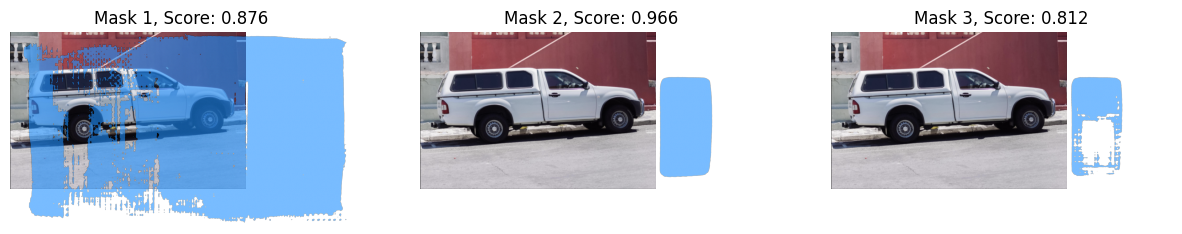

In [50]:
show_masks_on_image(raw_image, masks[0], scores)

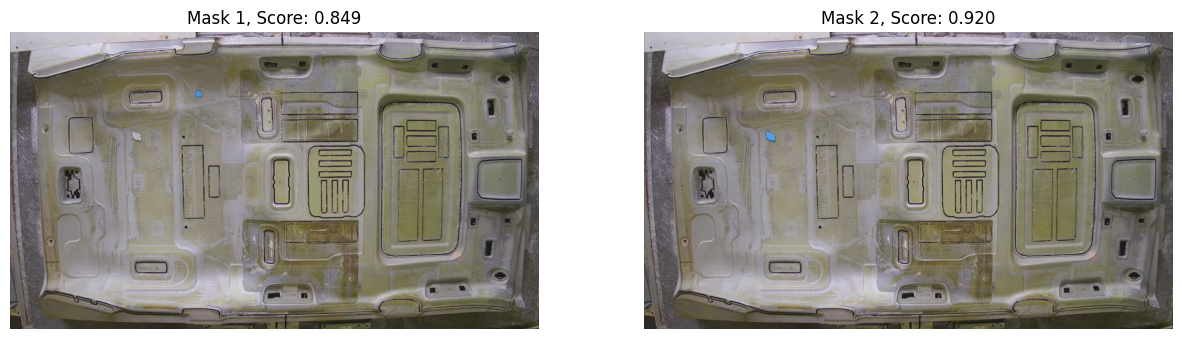

In [80]:
show_masks_on_image(industrial_image, masks[0], scores)

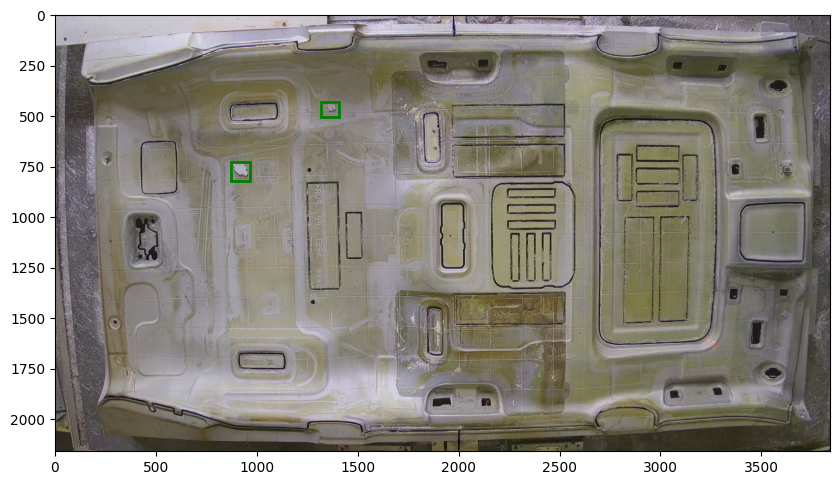

In [61]:
# Find the size of industrial_image
imsize = industrial_image.size
max_x = imsize[0]
max_y = imsize[1]

# Mirror the coordinates
mirrored_boxes = [[max_x - box[2], box[1], max_x - box[0], box[3]] for box in boxes]

show_boxes_on_image(industrial_image, boxes)

In [56]:
# Find the size of industrial_image
industrial_image.size

(3840, 2160)

In [82]:
from ultralytics import YOLO

MODEL_PATH = "/Users/rstory/Repositories/Tim/runs/detect/train18/weights/best.pt"

# Load a model
model = YOLO(MODEL_PATH)  # load a custom model

def predict_on_image(model, image_path):
    # Predict with the model
    results = model(image_path)  # predict on an image
    return results

In [104]:
import os

# Load the first n images from the validation set and predict on them.
validation_directory = "/Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images"

def predict_on_n_validation_images(model, validation_directory, n=10):
    # Get the first n images from the validation set
    validation_images = os.listdir(validation_directory)[:n]
    for image in validation_images:
        image_path = os.path.join(validation_directory, image)
        raw_image = Image.open(image_path).convert("RGB")
        results = predict_on_image(model, image_path)
        boxes: list[list[float]] = []
        for item in results:
            box_tensor = item.boxes.xyxy.numpy()
            # If there's more than one box identified, add them all
            if len(box_tensor.shape) == 2:
                for box in box_tensor:
                    boxes.append(box)
            else:
                boxes.append(box_tensor[0])

        print(boxes)
        show_boxes_on_image(raw_image, boxes)


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240227165914-PB2 Waterjet Lorax channel 1-1203-0-4 59 14 PM.jpg: 384x640 1 debris, 45.7ms
Speed: 1.3ms preprocess, 45.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
[[     1866.2      1515.7      1977.8        1627]]
(1, 4)
[array([     1866.2,      1515.7,      1977.8,        1627], dtype=float32)]


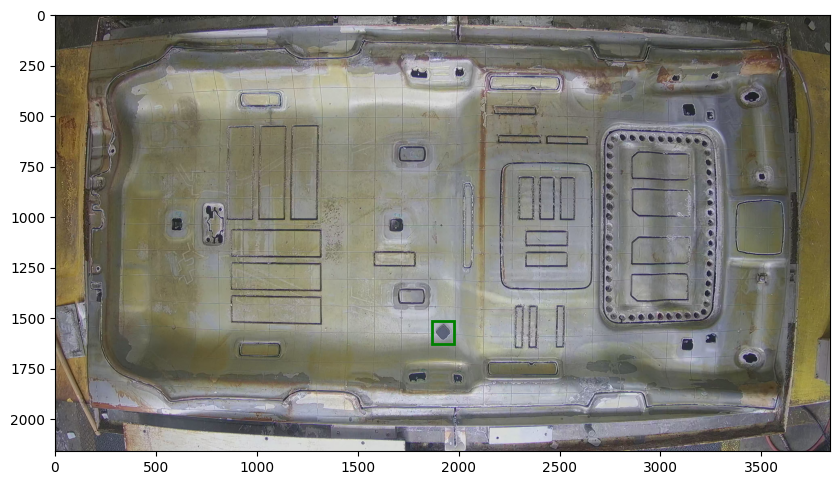


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240228175025-PB2 Waterjet Lorax channel 1-1203-0-5 50 25 PM.jpg: 384x640 1 debris, 64.1ms
Speed: 2.8ms preprocess, 64.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[       1563      1214.1      1664.1        1298]]
(1, 4)
[array([       1563,      1214.1,      1664.1,        1298], dtype=float32)]


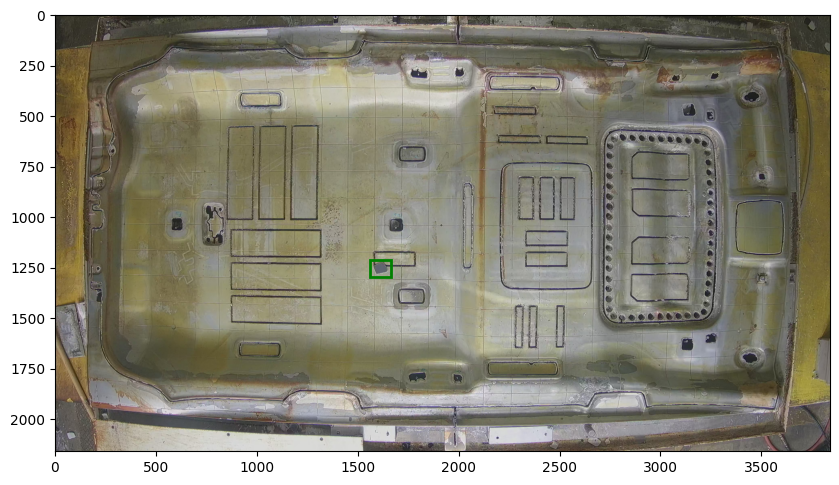


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240304062217-PB2 Waterjet Lorax channel 1-1203-0-6 22 18 AM.jpg: 384x640 2 debriss, 45.2ms
Speed: 1.3ms preprocess, 45.2ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[     570.85      1124.1      664.58      1214.4]
 [     1794.1      1364.2      1892.9      1467.2]]
(2, 4)
[array([     570.85,      1124.1,      664.58,      1214.4], dtype=float32), array([     1794.1,      1364.2,      1892.9,      1467.2], dtype=float32)]


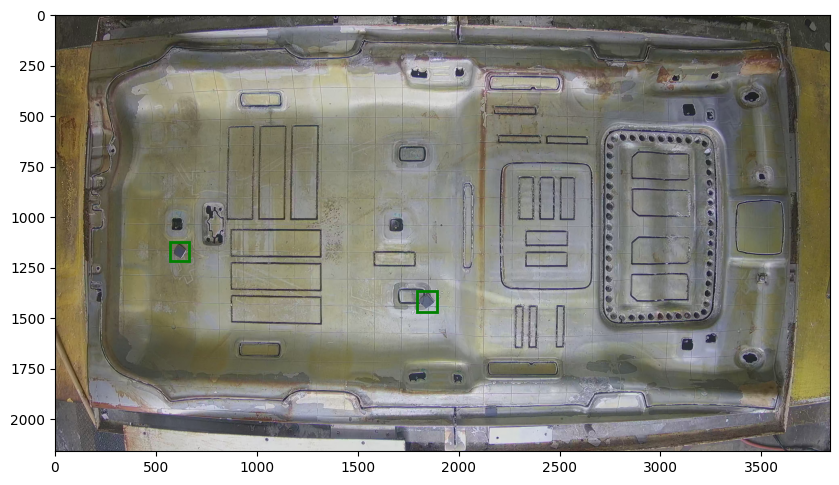


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240226010518-PB4 Waterjet Lorax channel 1-1229-0-1 05 18 AM.jpg: 384x640 3 debriss, 67.6ms
Speed: 2.4ms preprocess, 67.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[     2867.8      538.33      2964.4      630.72]
 [     3052.4      566.92      3150.8      666.13]
 [     2565.9      1495.2      2647.8      1573.6]]
(3, 4)
[array([     2867.8,      538.33,      2964.4,      630.72], dtype=float32), array([     3052.4,      566.92,      3150.8,      666.13], dtype=float32), array([     2565.9,      1495.2,      2647.8,      1573.6], dtype=float32)]


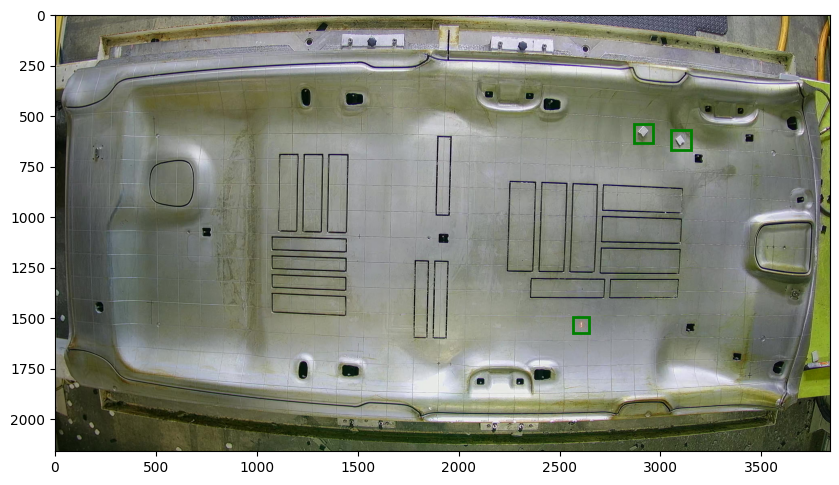


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240226015155-PB4 Waterjet Lorax channel 1-1229-0-1 51 56 AM.jpg: 384x640 2 debriss, 42.2ms
Speed: 1.4ms preprocess, 42.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
[[     3052.9      554.39      3149.4      650.76]
 [     3290.4      729.85      3378.1      820.49]]
(2, 4)
[array([     3052.9,      554.39,      3149.4,      650.76], dtype=float32), array([     3290.4,      729.85,      3378.1,      820.49], dtype=float32)]


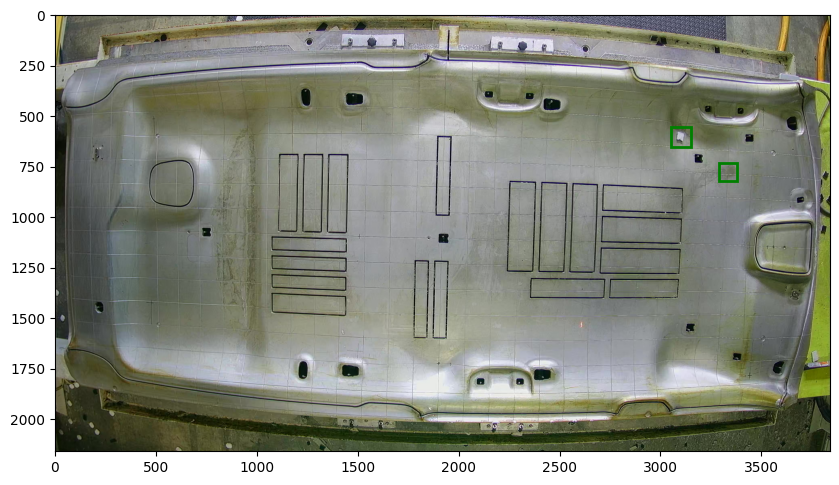


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240304062104-PB2 Waterjet Lorax channel 1-1203-0-6 21 04 AM.jpg: 384x640 3 debriss, 69.1ms
Speed: 2.4ms preprocess, 69.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[     1797.3      1364.8      1894.6      1468.1]
 [     577.14      1118.5      666.22      1206.5]
 [     2833.2      1367.7      2900.5      1438.9]]
(3, 4)
[array([     1797.3,      1364.8,      1894.6,      1468.1], dtype=float32), array([     577.14,      1118.5,      666.22,      1206.5], dtype=float32), array([     2833.2,      1367.7,      2900.5,      1438.9], dtype=float32)]


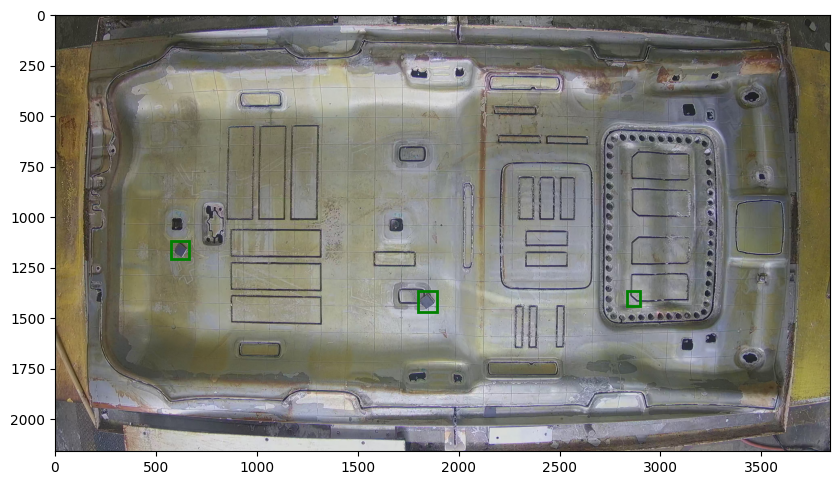


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240226052340-PB4 Waterjet Lorax channel 1-1229-0-5 23 41 AM.jpg: 384x640 3 debriss, 31.5ms
Speed: 1.6ms preprocess, 31.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[     2891.5      493.03        2990      585.29]
 [     1325.8      1241.5      1432.6      1351.8]
 [     2564.7      1499.5      2644.7      1576.8]]
(3, 4)
[array([     2891.5,      493.03,        2990,      585.29], dtype=float32), array([     1325.8,      1241.5,      1432.6,      1351.8], dtype=float32), array([     2564.7,      1499.5,      2644.7,      1576.8], dtype=float32)]


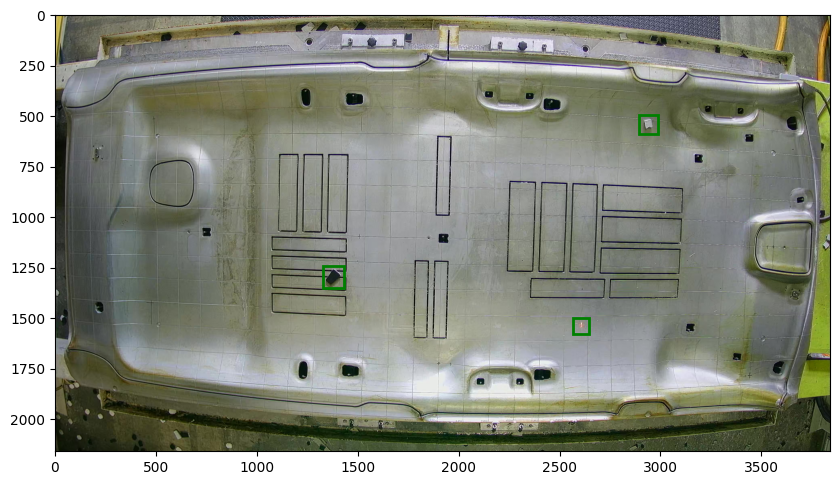


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240228175239-PB2 Waterjet Lorax channel 1-1203-0-5 52 40 PM.jpg: 384x640 1 debris, 64.2ms
Speed: 2.6ms preprocess, 64.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
[[     1557.5      1214.9      1655.7      1298.5]]
(1, 4)
[array([     1557.5,      1214.9,      1655.7,      1298.5], dtype=float32)]


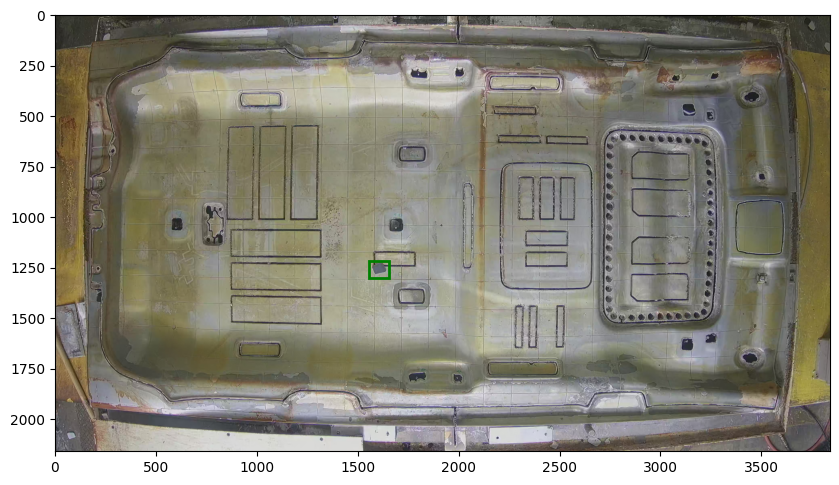


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240226040537-PB4 Waterjet Lorax channel 1-1229-0-4 05 38 AM.jpg: 384x640 3 debriss, 38.1ms
Speed: 1.4ms preprocess, 38.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[       1440      1598.9      1563.9      1698.1]
 [     3061.2      550.35        3152      642.01]
 [       2563      1500.7      2644.1      1573.3]]
(3, 4)
[array([       1440,      1598.9,      1563.9,      1698.1], dtype=float32), array([     3061.2,      550.35,        3152,      642.01], dtype=float32), array([       2563,      1500.7,      2644.1,      1573.3], dtype=float32)]


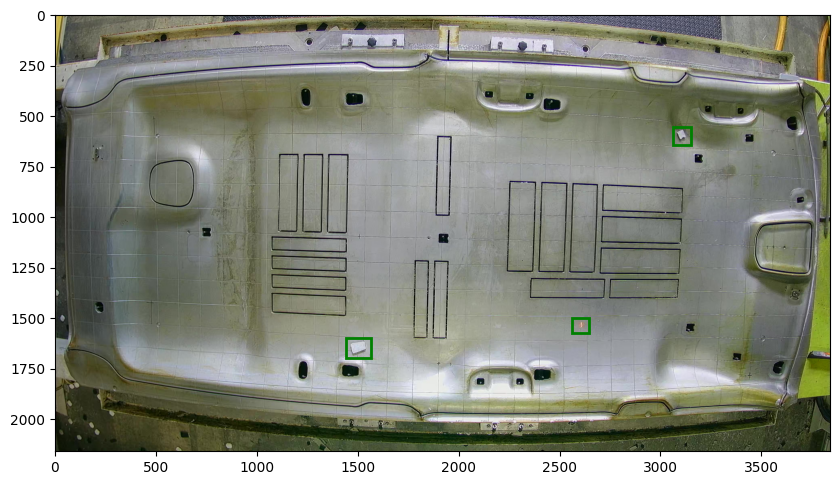


image 1/1 /Users/rstory/Repositories/Tim/data/d1000_debris_only_dataset_1/val/images/20240305134103-PB2 Waterjet Lorax channel 1-1202-0-1 41 04 PM.jpg: 384x640 1 debris, 54.9ms
Speed: 2.6ms preprocess, 54.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
[[     1802.2      1045.6      1880.1        1140]]
(1, 4)
[array([     1802.2,      1045.6,      1880.1,        1140], dtype=float32)]


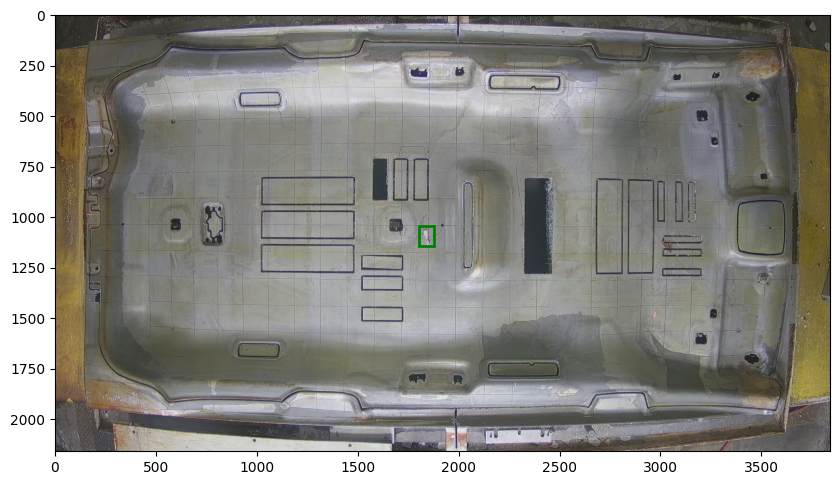

In [105]:
predict_on_n_validation_images(model, validation_directory, n=10)

In [107]:
Precision = 0.94782
Recall = 0.77419

F1 = 2 * (Precision * Recall) / (Precision + Recall)
F1

0.8522514570763237